In [308]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import glob
import os
import json


In [309]:
results = pd.read_csv("../private_data/private_analysis.csv")
results = results.set_index('Unnamed: 0')
results = results[['2']]
results.columns = ['value']

# First, let's reset the index to get the bugcheck_code as a column
results = results.reset_index()
results.columns = ['bugcheck_code', 'value']

# Create an empty DataFrame to store the parsed results
parsed_results = []

# Parse each row
for _, row in results.iterrows():
    bugcheck_code = row['bugcheck_code']
    # Replace numpy-specific strings with Python equivalents
    value_str = row['value'].replace('np.float64', 'float').replace('array', 'np.array')
    # Convert string representation of dict to actual dict
    data_dict = eval(value_str)
    
    # Extract data for each iteration
    for n_iter, values in data_dict.items():
        parsed_results.append({
            'bugcheck_code': bugcheck_code,
            'n_iter': n_iter,
            'epsilon': values['epsilon'],
            'loss': float(values['loss']),  # Convert np.float64 to regular float
            'param_0': float(values['params'][0]),  # Convert numpy array elements to float
            'param_1': float(values['params'][1])
        })

# Convert to DataFrame
results_df = pd.DataFrame(parsed_results)

In [310]:
results_df

,bugcheck_code,n_iter,epsilon,loss,param_0,param_1
0,230,1,0.014922,0.564298,-0.468381,-0.000461
1,230,2,0.018594,0.527496,-0.655861,0.014884
2,230,4,0.024517,0.489354,-0.916301,0.019218
3,230,8,0.033674,0.463784,-1.195249,0.029198
4,230,16,0.047426,0.452079,-1.472881,-0.045042
...,...,...,...,...,...,...
445,412,1024,0.425436,0.450643,-1.602681,-0.409668
446,412,2048,0.616395,0.450566,-1.608568,-0.835629
447,412,4096,0.894198,0.450468,-1.609158,-1.700939
448,412,8192,1.299718,0.450551,-1.635473,-1.356100


In [311]:
perm_df = pd.read_csv("../private_data/permutation_results/80.csv")
perm_df = perm_df.unstack().reset_index()
perm_df.columns = ["n_iter", "n_iter_idx", "value"]

In [312]:
def get_perm_df(bugcheck_id):
    perm_df = pd.read_csv(f"../private_data/permutation_results/{bugcheck_id}.csv")
    perm_df = perm_df.unstack().reset_index()
    perm_df.columns = ["n_iter", "n_iter_idx", "value"]
    perm_df['epsilon'] = perm_df['value'].apply(lambda x: re.findall(r"'epsilon': (\d+\.\d+)", str(x))[0])
    perm_df['loss'] = perm_df['value'].apply(lambda x: re.findall(r"'loss': np\.float64\((\d+\.\d+)\)", str(x))[0])
    perm_df['param_0'] = perm_df['value'].apply(lambda x: re.search(r"'params': array\(\[(-?\d+\.\d+).+ (-?\d+\.\d+)", str(x)).group(1))
    perm_df['param_1'] = perm_df['value'].apply(lambda x: re.search(r"'params': array\(\[(-?\d+\.\d+).+ (-?\d+\.\d+)", str(x)).group(2))
    perm_df = perm_df.drop(columns=['value'])
    perm_df[['epsilon', 'loss', 'param_0', 'param_1']] = perm_df[['epsilon', 'loss', 'param_0', 'param_1']].astype(float)
    perm_df[['n_iter', 'n_iter_idx']] = perm_df[['n_iter', 'n_iter_idx']].astype(int)
    
    return perm_df

In [313]:
def logistic_regression_wald_test_from_params(X, params):
    """
    Perform Wald test for a logistic regression coefficient using only parameters and X.
    
    Args:
        X (np.array): Feature matrix
        params (np.array): Model parameters/coefficients
        param_index (int): Index of the parameter to test (default=0 for first feature)
    
    Returns:
        dict: Contains test statistic, p-value, and standard error
    """
    # Get coefficient we want to test
    beta = params[1]
    
    # Calculate predicted probabilities
    z = X @ params  # Linear combination
    p = 1 / (1 + np.exp(-z))  # Logistic function
    
    # Get unique p values and their indices
    p0 = p[X[:, 1] == 0][0]  # p value when X=0
    p1 = p[X[:, 1] == 1][0]  # p value when X=1
    n0 = np.sum(X[:, 1] == 0)  # count of X=0
    n1 = np.sum(X[:, 1] == 1)  # count of X=1
    
    # Compute X.T @ W @ X directly
    # This is a 2x2 matrix:
    # [sum(p*(1-p))        sum(p*(1-p)*x)]
    # [sum(p*(1-p)*x)      sum(p*(1-p)*x*x)]
    w00 = n0 * p0 * (1-p0) + n1 * p1 * (1-p1)
    w01 = n1 * p1 * (1-p1)  # x is 1 for these terms
    w11 = n1 * p1 * (1-p1)  # x*x is 1 for these terms (since x is binary)
    
    information_matrix = np.array([[w00, w01],
                                 [w01, w11]])
    
    # Calculate inverse of information matrix
    # For 2x2 matrix, we can do this directly
    det = information_matrix[0,0] * information_matrix[1,1] - information_matrix[0,1]**2
    vcov = 1/det * np.array([[information_matrix[1,1], -information_matrix[0,1]],
                            [-information_matrix[0,1], information_matrix[0,0]]])
    
    # Get standard error for the coefficient
    std_err = np.sqrt(vcov[1, 1])
    
    # Calculate Wald statistic
    wald_stat = (beta / std_err) ** 2
    
    # Calculate p-value (chi-square with 1 df)
    p_value = 1 - stats.chi2.cdf(wald_stat, df=1)
    
    return {
        'coefficient': beta,
        'std_error': std_err,
        'wald_statistic': wald_stat,
        'p_value': p_value
    }

In [314]:
X_80 = pd.read_csv("../private_data/bugcheck_80.csv")
X_80 = X_80['has_corrected_error']
X_80 = X_80.to_numpy()
X_80 = X_80.reshape(-1, 1)
X_80 = np.concatenate([np.ones((X_80.shape[0], 1)), X_80], axis=1)

# params_80 = df_80[['param_0', 'param_1']].to_numpy()
result_80 = results_df[results_df['bugcheck_code'] == 80].sort_values(by='n_iter', ascending=False).iloc[0][['param_0', 'param_1']].to_numpy()

logistic_regression_wald_test_from_params(X_80, result_80)


{'coefficient': np.float64(-1.5809586),
 'std_error': np.float64(0.3396759791590173),
 'wald_statistic': np.float64(21.662637022086134),
 'p_value': np.float64(3.2506142054744558e-06)}

In [315]:
result_80 = results_df[results_df['bugcheck_code'] == 80]

In [316]:
df_80 = get_perm_df(80)
result_80 = results_df[results_df['bugcheck_code'] == 80]

df_80['wald_statistic'] = df_80.apply(lambda row: logistic_regression_wald_test_from_params(X_80, row[['param_0', 'param_1']].to_list())['wald_statistic'], axis=1)
result_80['wald_statistic'] = result_80.apply(lambda row: logistic_regression_wald_test_from_params(X_80, row[['param_0', 'param_1']].to_list())['wald_statistic'], axis=1)

KeyboardInterrupt: 

In [88]:
def get_percentile(val, arr):
    return np.sum(arr <= val) / len(arr)

def get_pval(val, arr):
    return 1 - get_percentile(val, arr)


In [85]:
result_80.loc[result_80['n_iter'] == 10670, 'wald_statistic']

29    21.662637
Name: wald_statistic, dtype: float64

In [89]:
get_pval(result_80.loc[result_80['n_iter'] == 10670, 'wald_statistic'].values[0], df_80.loc[df_80['n_iter'] == 10670, 'wald_statistic'])

np.float64(0.008000000000000007)

In [ ]:
df_80 = pd.merge(df_80, result_80[['n_iter', 'wald_statistic']], on='n_iter', how='left', suffixes=('', '_original'))

In [101]:
df_80.groupby('n_iter').apply(lambda x: get_pval(x['wald_statistic_original'].values[0], x['wald_statistic'])).to_dict()

/var/folders/_l/93v0jk4n5dz2_jcx0p69cbrh0000gn/T/ipykernel_6349/672473948.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_80.groupby('n_iter').apply(lambda x: get_pval(x['wald_statistic_original'].values[0], x['wald_statistic'])).to_dict()


{1: 0.4,
 2: 0.589,
 4: 0.571,
 8: 0.264,
 16: 0.05500000000000005,
 32: 0.07299999999999995,
 64: 0.10999999999999999,
 128: 0.11599999999999999,
 256: 0.039000000000000035,
 512: 0.23199999999999998,
 1024: 0.09799999999999998,
 2048: 0.01100000000000001,
 4096: 0.265,
 8192: 0.09299999999999997,
 10670: 0.008000000000000007}

In [92]:
result_80

,bugcheck_code,n_iter,epsilon,loss,param_0,param_1,wald_statistic
15,80,1,0.014922,0.451341,-1.509292,-0.009207,0.002844
16,80,2,0.018594,0.450767,-1.564712,-0.008044,0.002096
17,80,4,0.024517,0.450624,-1.609933,-0.009933,0.003098
18,80,8,0.033674,0.450622,-1.612751,-0.025963,0.020900
19,80,16,0.047426,0.450617,-1.604660,-0.074106,0.165700
20,80,32,0.067725,0.450613,-1.609964,-0.087161,0.226352
21,80,64,0.097396,0.450615,-1.603431,-0.098877,0.290254
22,80,128,0.140546,0.450624,-1.594117,-0.140913,0.576255
23,80,256,0.203146,0.450594,-1.603256,-0.281365,2.063638
24,80,512,0.293883,0.450595,-1.605672,-0.255842,1.735348


In [90]:
results = pd.read_csv("../private_data/private_analysis.csv")
results = results.set_index('Unnamed: 0')
results = results[['2']]
results.columns = ['value']

# First, let's reset the index to get the bugcheck_code as a column
results = results.reset_index()
results.columns = ['bugcheck_code', 'value']

# Create an empty DataFrame to store the parsed results
parsed_results = []

# Parse each row
for _, row in results.iterrows():
    bugcheck_code = row['bugcheck_code']
    # Replace numpy-specific strings with Python equivalents
    value_str = row['value'].replace('np.float64', 'float').replace('array', 'np.array')
    # Convert string representation of dict to actual dict
    data_dict = eval(value_str)
    
    # Extract data for each iteration
    for n_iter, values in data_dict.items():
        parsed_results.append({
            'bugcheck_code': bugcheck_code,
            'n_iter': n_iter,
            'epsilon': values['epsilon'],
            'loss': float(values['loss']),  # Convert np.float64 to regular float
            'param_0': float(values['params'][0]),  # Convert numpy array elements to float
            'param_1': float(values['params'][1])
        })

# Convert to DataFrame
results_df = pd.DataFrame(parsed_results)

results_df['wald_statistic'] = results_df.apply(lambda row: logistic_regression_wald_test_from_params(X_80, row[['param_0', 'param_1']].to_list())['wald_statistic'], axis=1)
results_df.head()

,bugcheck_code,n_iter,epsilon,loss,param_0,param_1,wald_statistic
0,230,1,0.014922,0.564298,-0.468381,-0.000461,0.000011
1,230,2,0.018594,0.527496,-0.655861,0.014884,0.011397
2,230,4,0.024517,0.489354,-0.916301,0.019218,0.017299
3,230,8,0.033674,0.463784,-1.195249,0.029198,0.035152
4,230,16,0.047426,0.452079,-1.472881,-0.045042,0.068106


In [ ]:
data_dir = "../private_data/permutation_results"

fps = glob.glob(os.path.join(data_dir, "*.csv"))
bugcheck_ids = [int(fp.split("/")[-1].split(".")[0]) for fp in fps]

results = {}

for bugcheck_id in bugcheck_ids:
    try:
        perm_df = get_perm_df(bugcheck_id)
    except:
        raise Exception(f"Error getting perm_df for {bugcheck_id}")
    result_id = results_df[results_df['bugcheck_code'] == bugcheck_id]

    perm_df['wald_statistic'] = perm_df.apply(lambda row: logistic_regression_wald_test_from_params(X_80, row[['param_0', 'param_1']].to_list())['wald_statistic'], axis=1)
    perm_df = pd.merge(perm_df, result_id[['n_iter', 'wald_statistic']], on='n_iter', how='left', suffixes=('', '_original'))
    
    results[bugcheck_id] = perm_df.groupby('n_iter').apply(lambda x: get_pval(x['wald_statistic_original'].values[0], x['wald_statistic']), include_groups=False).to_dict()
    
    print(f"Completed {bugcheck_id}, eps = 2 pval = {results[bugcheck_id][10670]}")

# Redos
# 26: 0.07
# 275: 0.09
# 314: 0.05
# 307: 0.04

Completed 156, eps = 2 pval = 0.266
Completed 80, eps = 2 pval = 0.008000000000000007
Completed 340, eps = 2 pval = 0.07699999999999996
Completed 209, eps = 2 pval = 0.01100000000000001
Completed 230, eps = 2 pval = 0.374
Completed 122, eps = 2 pval = 0.30000000000000004
Completed 335, eps = 2 pval = 0.12
Completed 269, eps = 2 pval = 0.22999999999999998
Completed 257, eps = 2 pval = 0.14
Completed 281, eps = 2 pval = 0.12
Completed 30, eps = 2 pval = 0.63
Completed 292, eps = 2 pval = 0.991
Completed 127, eps = 2 pval = 0.46699999999999997
Completed 26, eps = 2 pval = 0.06999999999999995
Completed 126, eps = 2 pval = 0.0
Completed 278, eps = 2 pval = 0.0
Completed 275, eps = 2 pval = 0.08999999999999997
Completed 314, eps = 2 pval = 0.050000000000000044
Completed 10, eps = 2 pval = 0.87
Completed 307, eps = 2 pval = 0.040000000000000036
Completed 313, eps = 2 pval = 0.10999999999999999
Completed 299, eps = 2 pval = 0.09999999999999998
Completed 270, eps = 2 pval = 0.37
Completed 265, 

In [235]:
json.dumps(results)

'{"156": {"1": 0.31499999999999995, "2": 0.29200000000000004, "4": 0.31899999999999995, "8": 0.6759999999999999, "16": 0.6950000000000001, "32": 0.23099999999999998, "64": 0.18300000000000005, "128": 0.33599999999999997, "256": 0.31799999999999995, "512": 0.44799999999999995, "1024": 0.529, "2048": 0.604, "4096": 0.29300000000000004, "8192": 0.44999999999999996, "10670": 0.266}, "80": {"1": 0.4, "2": 0.589, "4": 0.571, "8": 0.264, "16": 0.05500000000000005, "32": 0.07299999999999995, "64": 0.10999999999999999, "128": 0.11599999999999999, "256": 0.039000000000000035, "512": 0.23199999999999998, "1024": 0.09799999999999998, "2048": 0.01100000000000001, "4096": 0.265, "8192": 0.09299999999999997, "10670": 0.008000000000000007}, "340": {"1": 0.765, "2": 0.45999999999999996, "4": 0.22999999999999998, "8": 0.474, "16": 0.09099999999999997, "32": 0.615, "64": 0.531, "128": 0.08299999999999996, "256": 0.041000000000000036, "512": 0.05500000000000005, "1024": 0.0020000000000000018, "2048": 0.00

In [236]:
# Load the JSON data from the file
with open('../private_data/permutation_stuff/first_results.json', 'r') as f:
    p_val_dict = json.load(f)


In [274]:
significant_raw = pd.DataFrame(p_val_dict).T
significant_raw = significant_raw.unstack().reset_index()
significant_raw.columns = ['n_iter', 'bugcheck_code', 'p_val']
significant_raw[['n_iter', 'bugcheck_code']] = significant_raw[['n_iter', 'bugcheck_code']].astype(int)
significant_raw = pd.merge(significant_raw, results_df[['n_iter', 'epsilon']].groupby('n_iter').first(), on='n_iter', how='left')
significant = significant_raw[significant_raw['p_val'] < 0.05]
significant


,n_iter,bugcheck_code,p_val,epsilon
92,8,122,0.040,0.033674
121,16,122,0.030,0.047426
144,16,59,0.030,0.047426
148,32,209,0.049,0.067725
150,32,122,0.020,0.067725
...,...,...,...,...
421,10670,278,0.000,1.499950
425,10670,307,0.040,1.499950
432,10670,239,0.000,1.499950
433,10670,159,0.000,1.499950


In [238]:
private_set = significant.groupby('n_iter')['bugcheck_code'].apply(lambda x: set(x.to_list()))
private_set

n_iter
8                                                    {122}
16                                               {122, 59}
32                                         {209, 122, 278}
64                                         {159, 122, 335}
128                                   {159, 209, 122, 335}
256        {160, 335, 80, 209, 239, 340, 26, 59, 126, 159}
512                                   {281, 275, 126, 159}
1024     {270, 335, 239, 209, 275, 340, 307, 281, 26, 1...
2048     {26, 270, 335, 80, 209, 239, 275, 340, 307, 27...
4096     {160, 26, 126, 270, 239, 209, 275, 340, 307, 2...
8192     {26, 335, 239, 209, 275, 278, 313, 122, 126, 159}
10670               {239, 80, 209, 307, 278, 59, 126, 159}
Name: bugcheck_code, dtype: object

In [239]:
nonprivate = pd.read_csv("../private_data/nonprivate_analysis.csv")
nonprivate = nonprivate.rename(columns={'Unnamed: 0': 'bugcheck_code'})
nonprivate = nonprivate[nonprivate['bugcheck_code'] != 0]
for bugcheck_code in nonprivate['bugcheck_code'].unique():
    n = pd.read_csv(f"../private_data/bugcheck_{bugcheck_code}.csv").shape[0]
    nonprivate.loc[nonprivate['bugcheck_code'] == bugcheck_code, 'n'] = n
nonprivate_set = set(nonprivate.loc[nonprivate['pvalue'] < 0.05, 'bugcheck_code'].to_list())
nonprivate_set

{26,
 59,
 80,
 122,
 126,
 159,
 160,
 209,
 239,
 269,
 270,
 275,
 278,
 281,
 292,
 299,
 307,
 313,
 314,
 335,
 340,
 412}

In [240]:
def intersection_over_union(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [241]:
iou = private_set.apply(lambda x: intersection_over_union(x, nonprivate_set)).sort_index()
iou = pd.DataFrame(iou).reset_index()
iou.columns = ['n_iter', 'iou']
iou = pd.merge(iou, results_df[['n_iter', 'epsilon']].groupby('n_iter').first(), on='n_iter', how='left')
iou

,n_iter,iou,epsilon
0,8,0.045455,0.033674
1,16,0.090909,0.047426
2,32,0.136364,0.067725
3,64,0.136364,0.097396
4,128,0.181818,0.140546
5,256,0.454545,0.203146
6,512,0.181818,0.293883
7,1024,0.500000,0.425436
8,2048,0.636364,0.616395
9,4096,0.565217,0.894198


In [242]:
nonprivate['bugcheck_code'].value_counts().shape

(29,)

In [243]:
# Create a confusion matrix for private_set[4096]
ground_truth_significant = nonprivate_set
ground_truth_not_significant = set(nonprivate['bugcheck_code']) - ground_truth_significant
private_significant = private_set[4096]
private_not_significant = set(nonprivate['bugcheck_code']) - private_significant

# Create the confusion matrix
true_positive = len(ground_truth_significant.intersection(private_significant))
false_positive = len(private_significant) - true_positive
false_negative = len(ground_truth_significant) - true_positive
true_negative = len(ground_truth_not_significant.intersection(private_not_significant))

confusion_matrix = pd.DataFrame(
    [[true_positive, false_positive],
     [false_negative, true_negative]],
    index=['Predicted Significant', 'Predicted Not Significant'],
    columns=['Significant', 'Not Significant']
)

confusion_matrix


,Significant,Not Significant
Predicted Significant,13,1
Predicted Not Significant,9,6


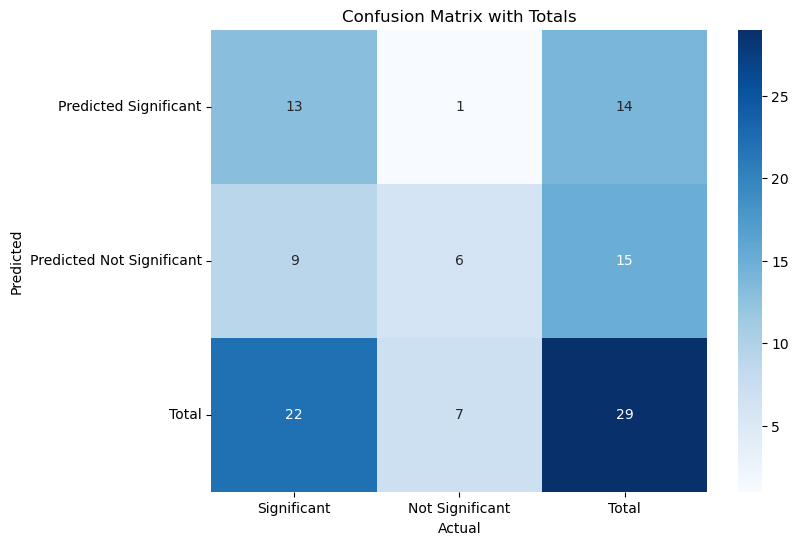

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add totals to the confusion matrix
confusion_matrix.loc['Total'] = confusion_matrix.sum()
confusion_matrix['Total'] = confusion_matrix.sum(axis=1)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix with Totals')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()


In [319]:
def plot_confusion_matrix_with_n(ground_truth_significant, ground_truth_not_significant, 
                               private_significant, private_not_significant, n_dict):
    """
    Create a scatter plot version of confusion matrix where each point is a bugcheck_code
    and size represents n.
    
    Args:
        ground_truth_significant: set of actually significant bugcheck codes
        ground_truth_not_significant: set of actually not significant bugcheck codes
        private_significant: set of privately predicted significant bugcheck codes
        private_not_significant: set of privately predicted not significant bugcheck codes
        n_dict: dictionary mapping bugcheck_code to n
    """
    def rScale(n):
        return np.sqrt(n)
    n_dict = {key: rScale(value) for key, value in n_dict.items()}
    
    # Create figure
    plt.figure(figsize=(10, 10))
    
    # Calculate points for each quadrant
    true_positives = ground_truth_significant.intersection(private_significant)
    false_positives = private_significant.intersection(ground_truth_not_significant)
    false_negatives = ground_truth_significant.intersection(private_not_significant)
    true_negatives = ground_truth_not_significant.intersection(private_not_significant)
    
    # Add some jitter to spread out points
    def jitter(n_points):
        return np.random.normal(0, 0.1, n_points)
    
    # Plot each quadrant
    # True Positives (upper right)
    for code in true_positives:
        plt.scatter(1 + jitter(1), 1 + jitter(1), 
                   s=n_dict[code], alpha=0.6, label=code if code == list(true_positives)[0] else "")
    
    # False Positives (upper left)
    for code in false_positives:
        plt.scatter(0 + jitter(1), 1 + jitter(1), 
                   s=n_dict[code], alpha=0.6, label=code if code == list(false_positives)[0] else "")
    
    # False Negatives (lower right)
    for code in false_negatives:
        plt.scatter(1 + jitter(1), 0 + jitter(1), 
                   s=n_dict[code], alpha=0.6, label=code if code == list(false_negatives)[0] else "")
    
    # True Negatives (lower left)
    for code in true_negatives:
        plt.scatter(0 + jitter(1), 0 + jitter(1), 
                   s=n_dict[code], alpha=0.6, label=code if code == list(true_negatives)[0] else "")
    
    # Add labels and grid
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix with Sample Sizes")
    
    # Set axis labels
    plt.xticks([0, 1], ["Not Significant", "Significant"])
    plt.yticks([0, 1], ["Not Significant", "Significant"])
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(title="Bugcheck Codes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add counts in each quadrant
    plt.text(1, 1, f"n={len(true_positives)}", ha='center', va='bottom')
    plt.text(0, 1, f"n={len(false_positives)}", ha='center', va='bottom')
    plt.text(1, 0, f"n={len(false_negatives)}", ha='center', va='bottom')
    plt.text(0, 0, f"n={len(true_negatives)}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

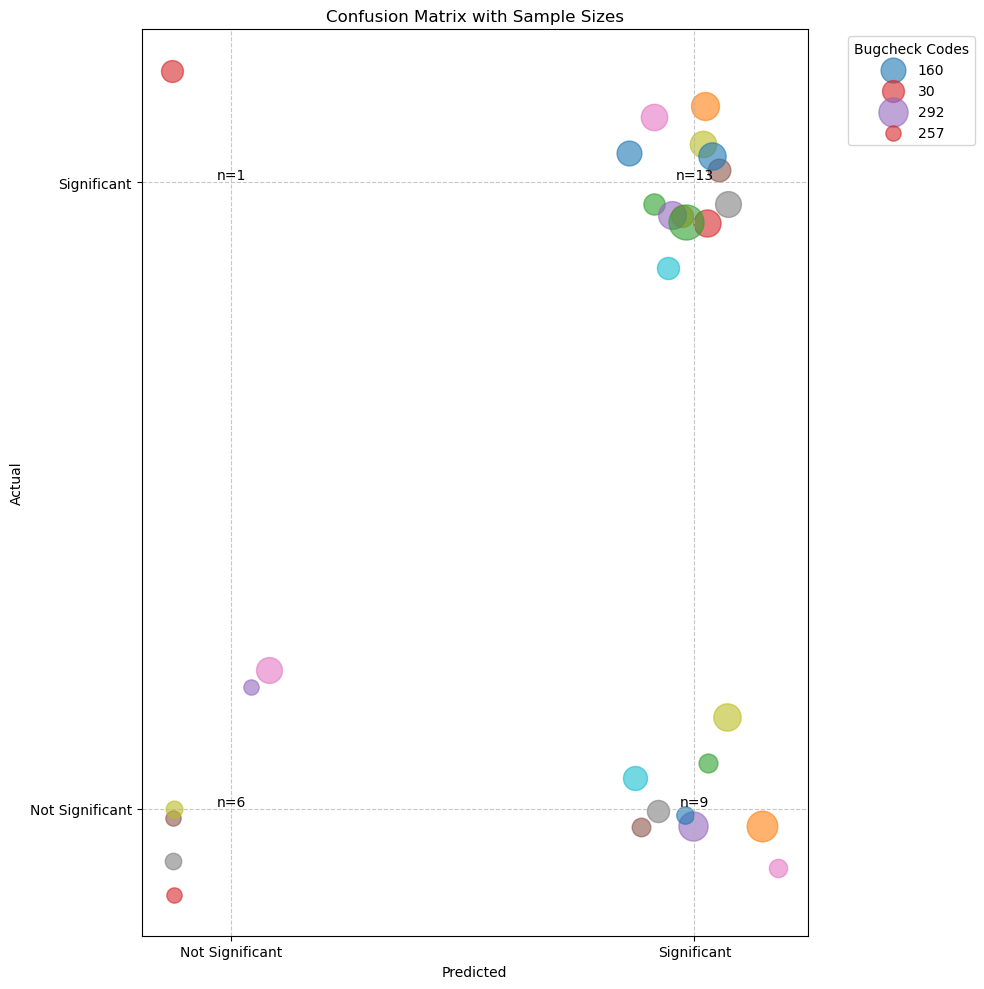

In [320]:
plot_confusion_matrix_with_n(ground_truth_significant, ground_truth_not_significant, private_significant, private_not_significant, nonprivate[['bugcheck_code', 'n']].set_index('bugcheck_code').to_dict()['n'])

In [245]:
private_set[4096]

{26, 30, 122, 126, 159, 160, 209, 239, 270, 275, 278, 281, 307, 340}

In [246]:
nonprivate['loss'].mean()

np.float64(0.4504475099514239)

In [247]:
results_df

,bugcheck_code,n_iter,epsilon,loss,param_0,param_1,wald_statistic
0,230,1,0.014922,0.564298,-0.468381,-0.000461,0.000011
1,230,2,0.018594,0.527496,-0.655861,0.014884,0.011397
2,230,4,0.024517,0.489354,-0.916301,0.019218,0.017299
3,230,8,0.033674,0.463784,-1.195249,0.029198,0.035152
4,230,16,0.047426,0.452079,-1.472881,-0.045042,0.068106
...,...,...,...,...,...,...,...
445,412,1024,0.425436,0.450643,-1.602681,-0.409668,3.975363
446,412,2048,0.616395,0.450566,-1.608568,-0.835629,11.690007
447,412,4096,0.894198,0.450468,-1.609158,-1.700939,22.410139
448,412,8192,1.299718,0.450551,-1.635473,-1.356100,19.077575


# Plots

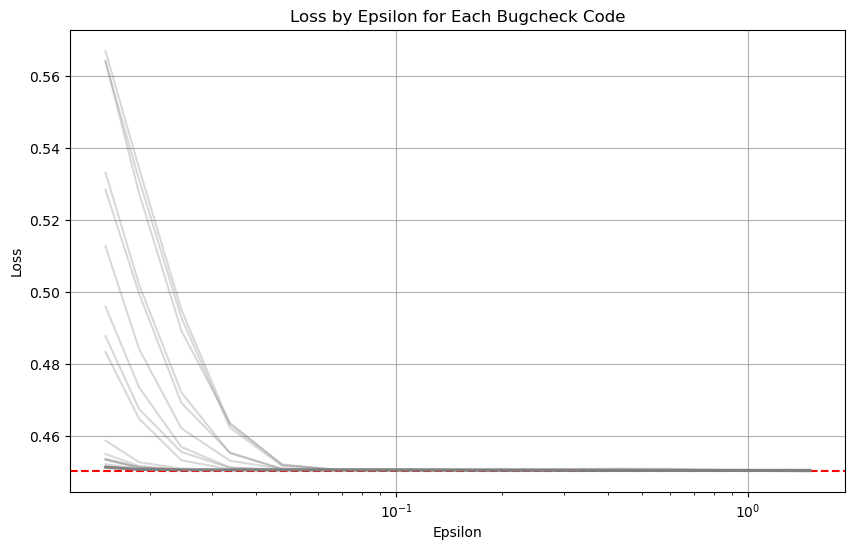

In [ ]:
plt.figure(figsize=(10, 6))

mean_loss = nonprivate['loss'].mean()
plt.axhline(mean_loss, color='red', linestyle='--', label='Mean Loss')
# Plot each bugcheck code with its own line
for bugcheck_code in results_df['bugcheck_code'].unique():
    subset = results_df[results_df['bugcheck_code'] == bugcheck_code]
    plt.plot(subset['epsilon'], subset['loss'], label=f'Bugcheck Code {bugcheck_code}', color='gray', alpha=0.3)

# Add a horizontal line for the mean loss


plt.title('Loss by Epsilon for Each Bugcheck Code')
plt.xlabel('Epsilon')
plt.xscale('log')
plt.ylabel('Loss')
# plt.yscale('log')
plt.legend().remove()
plt.grid()
plt.show()


## Together graph

In [249]:
metaanalysis_df = iou[['epsilon', 'iou']]
metaanalysis_df['task'] = "LR_PVAL"
metaanalysis_df.columns = ['epsilon', 'utility', 'task']
metaanalysis_df

,epsilon,utility,task
0,0.033674,0.045455,LR_PVAL
1,0.047426,0.090909,LR_PVAL
2,0.067725,0.136364,LR_PVAL
3,0.097396,0.136364,LR_PVAL
4,0.140546,0.181818,LR_PVAL
5,0.203146,0.454545,LR_PVAL
6,0.293883,0.181818,LR_PVAL
7,0.425436,0.500000,LR_PVAL
8,0.616395,0.636364,LR_PVAL
9,0.894198,0.565217,LR_PVAL


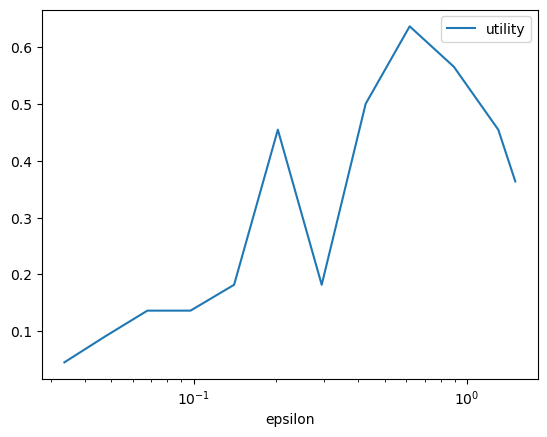

In [251]:
metaanalysis_df.plot(x='epsilon', y='utility', kind='line')
plt.xscale('log')

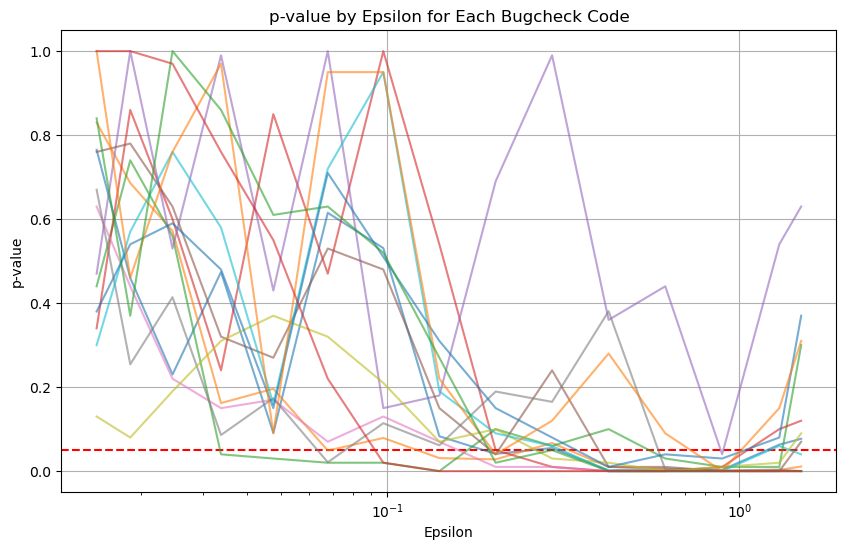

In [284]:
plt.figure(figsize=(10, 6))

plt.axhline(0.05, color='red', linestyle='--', label='Mean Loss')
# Plot each bugcheck code with its own line
for bugcheck_code in significant_raw['bugcheck_code'].unique():
    if significant_raw[significant_raw['bugcheck_code'] == bugcheck_code].loc[significant_raw['n_iter'] == 4096, 'p_val'].values[0] > 0.05:
        continue
    subset = significant_raw[significant_raw['bugcheck_code'] == bugcheck_code]
    plt.plot(subset['epsilon'], subset['p_val'], label=f'Bugcheck Code {bugcheck_code}', alpha=0.6)

# Add a horizontal line for the mean loss


plt.title('p-value by Epsilon for Each Bugcheck Code')
plt.xlabel('Epsilon')
plt.xscale('log')
plt.ylabel('p-value')
# plt.yscale('log')
plt.legend().remove()
plt.grid()
plt.show()


In [300]:
sig_at_1 = significant_raw.groupby('bugcheck_code').filter(lambda x: x.loc[x['n_iter'] == 4096, 'p_val'] < 0.05)
sig_at_1[sig_at_1['n_iter'] == 10670].sort_values(by='p_val')


,n_iter,bugcheck_code,p_val,epsilon
420,10670,126,0.000,1.49995
421,10670,278,0.000,1.49995
432,10670,239,0.000,1.49995
433,10670,159,0.000,1.49995
409,10670,209,0.011,1.49995
425,10670,307,0.040,1.49995
419,10670,26,0.070,1.49995
408,10670,340,0.077,1.49995
422,10670,275,0.090,1.49995
415,10670,281,0.120,1.49995
